In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from tqdm import tqdm


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_ROOT = DATA_ROOT = "../mvtec_anomaly_detection"
IMAGE_SIZE = 224
BATCH_SIZE = 8

products = [
    "bottle", "cable", "capsule", "carpet", "grid",
    "hazelnut", "leather", "metal_nut", "pill", "screw",
    "tile", "toothbrush", "transistor", "wood", "zipper"
]


In [3]:
class MVTecDataset(Dataset):
    def __init__(self, root, product, split):
        self.samples = []
        base = os.path.join(root, product)

        if split == "train":
            img_dir = os.path.join(base, "train", "good")
            for f in os.listdir(img_dir):
                self.samples.append((os.path.join(img_dir, f), None))

        else:  # test
            test_dir = os.path.join(base, "test")
            for defect_type in os.listdir(test_dir):
                img_dir = os.path.join(test_dir, defect_type)
                for f in os.listdir(img_dir):
                    mask = None
                    if defect_type != "good":
                        mask = os.path.join(
                            base, "ground_truth", defect_type,
                            f.replace(".png", "_mask.png")
                        )
                    self.samples.append((os.path.join(img_dir, f), mask))

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)

        if mask_path is None:
            dummy_mask = torch.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=torch.uint8)
            return img, dummy_mask
        else:
            mask = cv2.imread(mask_path, 0)
            mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
            mask = (mask > 0).astype(np.uint8)
            mask = torch.from_numpy(mask)
            return img, mask


In [4]:
class ResNet18FeatureMap(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(backbone.children())[:-2])

    def forward(self, x):
        return self.features(x)


In [5]:
def build_patch_bank(model, dataloader):
    model.eval()
    feats = []

    with torch.no_grad():
        for imgs, _ in tqdm(dataloader, leave=False):
            imgs = imgs.to(DEVICE)
            f = model(imgs)              # B × C × H × W
            f = f.permute(0, 2, 3, 1)    # B × H × W × C
            feats.append(f.reshape(-1, f.shape[-1]).cpu())

    return torch.cat(feats, dim=0)      # N × C


In [6]:
import torch.nn.functional as F

def compute_anomaly_map(model, memory_bank, img):
    model.eval()
    with torch.no_grad():
        f = model(img.unsqueeze(0).to(DEVICE))  # 1×C×H×W
        f = f.squeeze(0).permute(1, 2, 0)       # H×W×C
        f = f.reshape(-1, f.shape[-1])

        dists = torch.cdist(f, memory_bank)
        scores = dists.min(dim=1)[0]

        h = w = int(np.sqrt(scores.shape[0]))
        anomaly_map = scores.reshape(1, 1, h, w)

        # 🔥 UPSAMPLE về image size
        anomaly_map = F.interpolate(
            anomaly_map,
            size=(IMAGE_SIZE, IMAGE_SIZE),
            mode="bilinear",
            align_corners=False
        )

        return anomaly_map.squeeze().cpu().numpy()


In [7]:
def evaluate_product_pixel_auc(product):
    train_ds = MVTecDataset(DATA_ROOT, product, "train")
    test_ds  = MVTecDataset(DATA_ROOT, product, "test")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

    model = ResNet18FeatureMap().to(DEVICE)

    memory_bank = build_patch_bank(model, train_loader)

    pixel_scores = []
    pixel_labels = []

    for img, mask in tqdm(test_loader, leave=False):
        if mask is None:
            continue

        img = img.squeeze(0)
        anomaly_map = compute_anomaly_map(model, memory_bank, img)

        pixel_scores.extend(anomaly_map.flatten())
        pixel_labels.extend(mask.flatten())

    pixel_scores = np.array(pixel_scores)
    pixel_labels = np.array(pixel_labels).astype(np.uint8)

    return roc_auc_score(pixel_labels, pixel_scores)


In [8]:
pixel_results = {}

for p in products:
    auc = evaluate_product_pixel_auc(p)
    pixel_results[p] = auc
    print(f"{p:12s} Pixel AUROC: {auc:.4f}")


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


bottle       Pixel AUROC: 0.9387


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cable        Pixel AUROC: 0.9080


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


capsule      Pixel AUROC: 0.9465


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


carpet       Pixel AUROC: 0.8957


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packag

grid         Pixel AUROC: 0.5612


hazelnut     Pixel AUROC: 0.9623


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


leather      Pixel AUROC: 0.9198


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


metal_nut    Pixel AUROC: 0.9436


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


pill         Pixel AUROC: 0.9174


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


screw        Pixel AUROC: 0.8880


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tile         Pixel AUROC: 0.7699


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


toothbrush   Pixel AUROC: 0.9657


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


transistor   Pixel AUROC: 0.9143


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


wood         Pixel AUROC: 0.7547


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


zipper       Pixel AUROC: 0.9057


In [9]:
mean_auc = np.mean(list(pixel_results.values()))
print(f"\nMean Pixel AUROC over 15 products: {mean_auc:.4f}")



Mean Pixel AUROC over 15 products: 0.8794


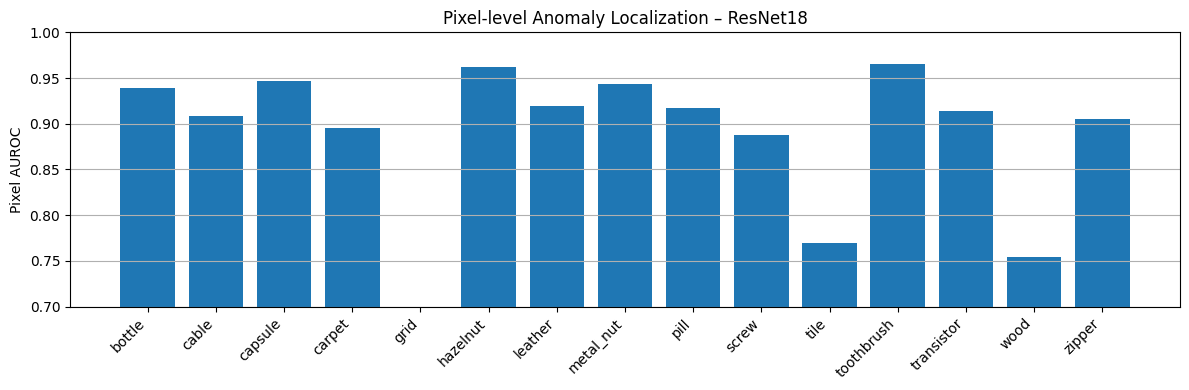

In [10]:
plt.figure(figsize=(12,4))
plt.bar(pixel_results.keys(), pixel_results.values())
plt.xticks(rotation=45, ha="right")
plt.ylabel("Pixel AUROC")
plt.title("Pixel-level Anomaly Localization – ResNet18")
plt.ylim(0.7, 1.0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()
